# Animation

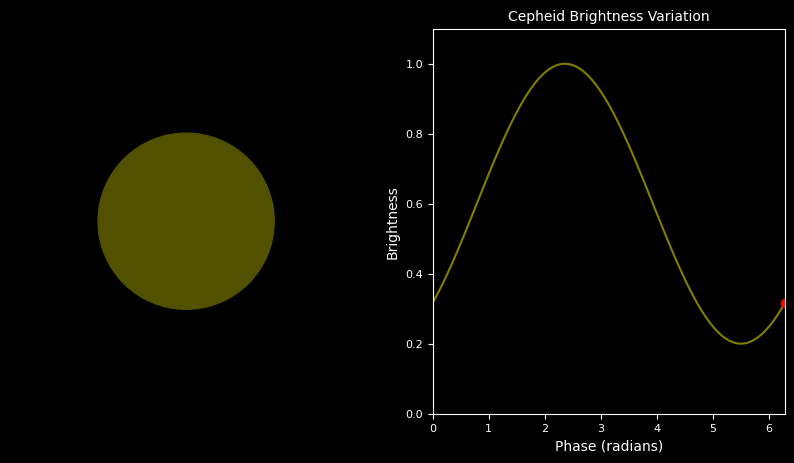

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# --- Parameters ---
period = 3.0  # seconds per pulsation
fps = 30
total_frames = int(period * fps)

# --- Star properties ---
base_radius = 0.5
radius_amplitude = 0.15
base_brightness = 0.6
brightness_amplitude = 0.4
phase_lag = np.pi / 4  # brightness lags radius

# --- Precompute data for brightness curve ---
phases = np.linspace(0, 2 * np.pi, total_frames)
radius_vals = base_radius + radius_amplitude * np.sin(phases)
brightness_vals = base_brightness + brightness_amplitude * np.sin(phases - phase_lag)
brightness_vals = np.clip(brightness_vals, 0, 1)

# --- Create figure with two panels ---
fig, (ax_star, ax_plot) = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_facecolor("black")

# --- Left panel: Star ---
ax_star.set_facecolor("black")
ax_star.set_xlim(-1, 1)
ax_star.set_ylim(-1, 1)
ax_star.set_aspect("equal")
ax_star.axis("off")

# Star (Circle patch)
star = plt.Circle((0, 0), base_radius, color=(base_brightness, base_brightness, 0))
ax_star.add_patch(star)

# --- Right panel: Brightness plot ---
ax_plot.set_facecolor("black")
ax_plot.tick_params(colors="white", labelsize=8)
ax_plot.spines['bottom'].set_color('white')
ax_plot.spines['top'].set_color('white')
ax_plot.spines['left'].set_color('white')
ax_plot.spines['right'].set_color('white')
ax_plot.set_xlim(0, 2 * np.pi)
ax_plot.set_ylim(0, 1.1)
ax_plot.set_xlabel("Phase (radians)", color="white")
ax_plot.set_ylabel("Brightness", color="white")
ax_plot.set_title("Cepheid Brightness Variation", color="white", fontsize=10)

# Static brightness curve
ax_plot.plot(phases, brightness_vals, color="yellow", alpha=0.5)

# Marker showing current brightness
current_point, = ax_plot.plot([], [], "o", color="red")

# --- Update function ---
def update(frame):
    phase = phases[frame]
    radius = base_radius + radius_amplitude * np.sin(phase)
    brightness = base_brightness + brightness_amplitude * np.sin(phase - phase_lag)
    brightness = np.clip(brightness, 0, 1)

    # Update star
    color = (brightness, brightness, 0)
    star.set_radius(radius)
    star.set_color(color)

    # Update current point on brightness plot (must use sequences)
    current_point.set_data([phase], [brightness])
    return (star, current_point)


# --- Animate ---
ani = animation.FuncAnimation(
    fig,
    update,
    frames=total_frames,
    interval=1000 / fps,
    blit=True,
    repeat=True
)

# --- Save animation ---
ani.save(
    "cepheid_with_brightness.gif",
    writer="pillow",
    fps=fps,
    savefig_kwargs={"facecolor": "black"}
)

plt.show()


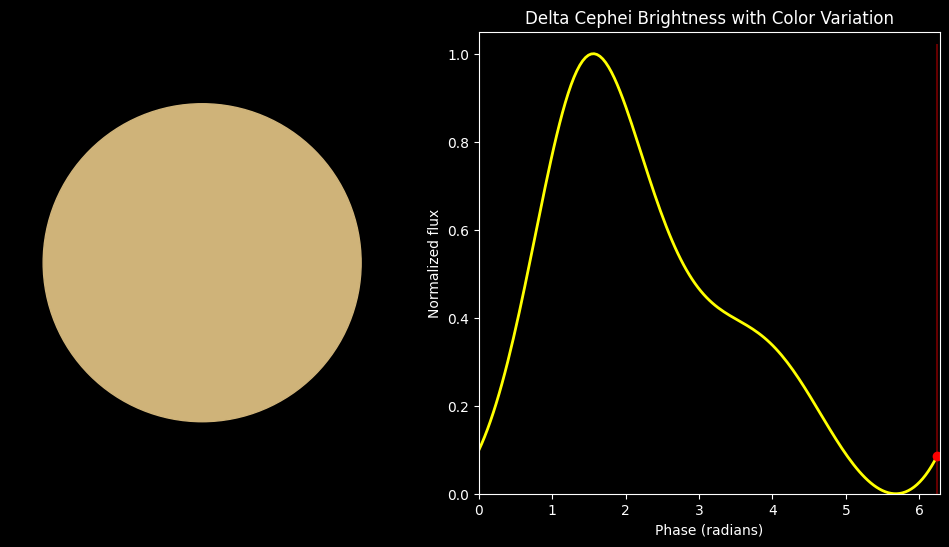

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors

# ---------- Parameters ----------
fps = 30
period = 5.366   # seconds (5.366 days)
frames = int(period * fps)

R0 = 1.0
A_r = 0.18
T0 = 1.0
A_t = 0.08
phase_lag = 0.35 * np.pi
A_t2 = 0.06
phi2 = -0.9

# Precompute phases
t = np.linspace(0, period, frames, endpoint=False)
phases = 2 * np.pi * t / period

# Radius & temperature arrays
radius = R0 * (1.0 + A_r * np.sin(phases))
temp = T0 * (1 + A_t * np.sin(phases - phase_lag) + A_t2 * np.sin(2*phases + phi2))
temp = np.clip(temp, 0.01, None)
luminosity = radius**2 * temp**4
flux = (luminosity - luminosity.min()) / (luminosity.max() - luminosity.min())

# ---------- Figure ----------
fig, (ax_star, ax_plot) = plt.subplots(1,2, figsize=(12,6), gridspec_kw={"width_ratios":[1,1.2]})
fig.patch.set_facecolor("black")

# Star panel
ax_star.set_facecolor("black")
ax_star.set_xlim(-1.2,1.2)
ax_star.set_ylim(-1.2,1.2)
ax_star.set_aspect("equal")
ax_star.axis("off")

# Pulsating star
star = plt.Circle((0,0), R0, color=(1.0,0.9,0.1), zorder=3)
ax_star.add_patch(star)

# Soft glow using scatter
glow = ax_star.scatter(0, 0, s=R0*500, color=(1.0,0.85,0.05,0.15), edgecolors='none', zorder=1)

# Brightness plot
ax_plot.set_facecolor("black")
for spine in ax_plot.spines.values(): spine.set_color("white")
ax_plot.tick_params(colors="white")
ax_plot.set_xlim(0,2*np.pi)
ax_plot.set_ylim(0,1.05)
ax_plot.set_xlabel("Phase (radians)", color="white")
ax_plot.set_ylabel("Normalized flux", color="white")
ax_plot.set_title("Delta Cephei Brightness with Color Variation", color="white")
ax_plot.plot(phases, flux, color="yellow", lw=2)

# Moving markers
current_point, = ax_plot.plot([],[], "o", color="red", markersize=6)
vertical_line, = ax_plot.plot([], [], color="red", alpha=0.4)

# ---------- Update function ----------
def update(i):
    r = radius[i]
    F = flux[i]

    # Update star radius
    star.set_radius(r)

    # ---------- Color variation with phase lag ----------
    phase_lag_color = 0 * np.pi
    temp_color = T0 * (
        1 + A_t * np.sin(phases[i] - phase_lag - phase_lag_color)
        + A_t2 * np.sin(2*phases[i] + phi2)
    )
    temp_color = np.clip(temp_color, 0.01, None)

    # Subtle HSV mapping around yellow
    temp_norm = (temp_color - temp.min()) / (temp.max() - temp.min())
    temp_norm = np.clip(temp_norm, 0, 1)
    
    # Hue: 0.13 (yellow) ±0.02
    hue_base = 0.13
    hue_range = 0.02
    hue = np.clip(hue_base - hue_range * (1 - temp_norm) + hue_range * temp_norm, 0, 1)
    
    # Saturation: slightly stronger at cooler phase
    saturation = 0.4 + 0.2 * temp_norm
    
    # Value: slightly brighter at maximum
    value = 0.8 + 0.15 * temp_norm

    color_rgb = np.clip(mcolors.hsv_to_rgb([hue, saturation, value]), 0, 1)
    star.set_color(color_rgb)

    # ---------- Soft glow ----------
    glow.set_sizes([r * 500])
    glow.set_alpha(0.05 + 0.2 * F)

    # ---------- Brightness graph ----------
    current_point.set_data([phases[i]], [F])
    vertical_line.set_data([phases[i], phases[i]], [0, 1.02])

    return (star, glow, current_point, vertical_line)


# ---------- Animate ----------
ani = animation.FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False, repeat=True)
ani.save("gif/delta_cephei_color_glow.gif", writer="pillow", fps=fps, savefig_kwargs={"facecolor":"black"})
plt.show()


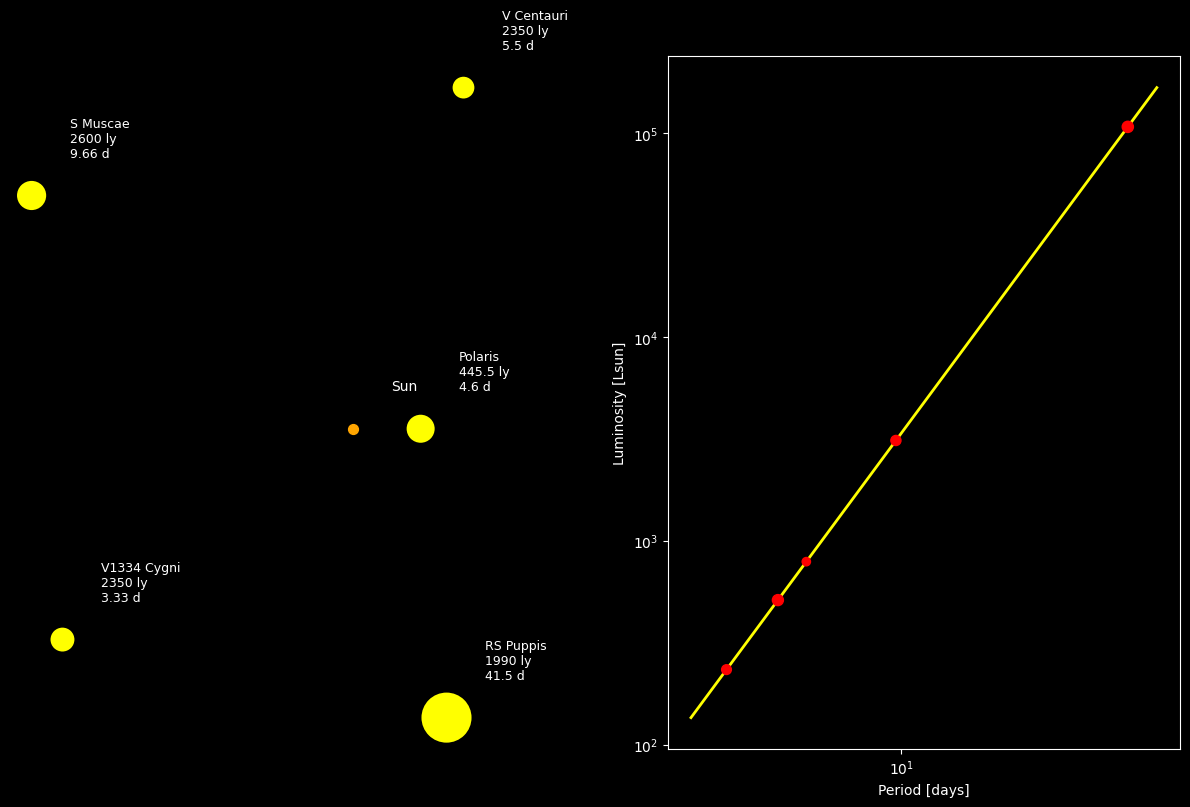

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parameters
fps = 30
total_frames = 300
distance_scale = 0.02
size_scale = 10  # base scale for visualization

# Five Cepheids: [name, distance (ly), period_days]
stars_data = [
    ("Polaris", 445.5, 4.6),
    ("V Centauri", 2350, 5.5),
    ("S Muscae", 2600, 9.66),
    ("V1334 Cygni", 2350, 3.33),
    ("RS Puppis", 1990, 41.5)
]

# Assign angular positions around Sun
angles = np.linspace(0, 2*np.pi, len(stars_data), endpoint=False)

# Scale positions
positions = []
for star, angle in zip(stars_data, angles):
    dist_scaled = star[1] * distance_scale
    x = dist_scaled * np.cos(angle)
    y = dist_scaled * np.sin(angle)
    positions.append((x, y))

# Compute base radius proportional to period
periods = np.array([star[2] for star in stars_data])
# Normalize periods for relative size
radii_base = 30 + (periods - min(periods)) / (max(periods) - min(periods)) * 70  # min 30, max 100
radii_base *= size_scale

# Compute luminosity using classical P-L relation
luminosities = 10**(2.43*np.log10(periods) + 1.1)

# Figure setup (16:9)
fig, (ax_anim, ax_PL) = plt.subplots(1, 2, figsize=(16,9), gridspec_kw={'width_ratios':[1.2,1]})
fig.patch.set_facecolor("black")
for ax in [ax_anim, ax_PL]:
    ax.set_facecolor("black")

# ---------- Animation panel ----------
ax_anim.set_aspect('equal')
ax_anim.axis("off")
# Draw Sun
ax_anim.scatter(0,0,s=50,color='orange',zorder=3)
ax_anim.text(5,5,"Sun", color='white', fontsize=10, zorder=4)

# Initialize stars
x_data = [pos[0] for pos in positions]
y_data = [pos[1] for pos in positions]
stars = ax_anim.scatter(x_data, y_data, s=radii_base, color='yellow', edgecolors='none', zorder=3)

# Annotations
annotations = []
for (x, y), (name, distance, period) in zip(positions, stars_data):
    text = f"{name}\n{distance} ly\n{period} d"
    annotation = ax_anim.text(x+5, y+5, text, color='white', fontsize=9, zorder=4)
    annotations.append(annotation)

# ---------- Period-Luminosity panel ----------
ax_PL.set_xlabel("Period [days]", color='white')
ax_PL.set_ylabel("Luminosity [Lsun]", color='white')
ax_PL.set_xscale('log')
ax_PL.set_yscale('log')
ax_PL.tick_params(colors='white')
for spine in ax_PL.spines.values():
    spine.set_color('white')

# P-L relation line
P_plot = np.linspace(min(periods)*0.8, max(periods)*1.2, 100)
L_plot = 10**(2.43*np.log10(P_plot) + 1.1)
ax_PL.plot(P_plot, L_plot, color='yellow', lw=2, label="Cepheid P-L relation")

# Red markers for stars
star_markers = ax_PL.scatter(periods, luminosities, s=[50]*len(periods), color='red', zorder=4)

# Update function
def update(frame):
    new_sizes_anim = []
    new_sizes_PL = []
    for j, (_, _, period_days) in enumerate(stars_data):
        phase = 2 * np.pi * (frame / fps) / (period_days )
        # Pulsation: scale around base radius
        r = radii_base[j] * (1 + 0.3 * np.sin(phase))
        new_sizes_anim.append(r)
        # P-L marker pulsates proportionally to brightness
        new_sizes_PL.append(50*(1 + 0.3*np.sin(phase)))
    stars.set_sizes(new_sizes_anim)
    star_markers.set_sizes(new_sizes_PL)
    return [stars, star_markers] + annotations

# Animate
ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=1000/fps, blit=False, repeat=True)

# Save GIF
ani.save("gif/five_cepheids_PL_relative_size.gif", writer="pillow", fps=fps, dpi=150, savefig_kwargs={"facecolor":"black"})

plt.show()
